# Day 9
## Part 1


In [1]:
from advent import read_input, Point, north, south, east, west, directions
import itertools
import numpy as np
from PIL import Image
import tqdm

def parse_data(s):
    return [
        Point(*map(int, line.split(","))) 
        for line in s.strip().splitlines()
    ]

test_data = parse_data("""7,1
11,1
11,7
9,7
9,5
2,5
2,3
7,3
""")

test_data

[Point(x=7, y=1),
 Point(x=11, y=1),
 Point(x=11, y=7),
 Point(x=9, y=7),
 Point(x=9, y=5),
 Point(x=2, y=5),
 Point(x=2, y=3),
 Point(x=7, y=3)]

In [2]:
def area(p1, p2):
    return abs(p1.x - p2.x + 1) * abs(p1.y - p2.y + 1)

def part_1(data):
    return max(
        area(p1, p2) 
        for p1, p2 in itertools.combinations(data, 2)
    )

assert part_1(test_data) == 50

In [3]:
data = parse_data(read_input())

part_1(data)

4777824480

## Part 2

I'm sure we've had something like this before. 

In [4]:
def boundaries(data):
    return[
        (p1, p2) 
        for p1, p2 in itertools.combinations(data, 2)
        if p1.x == p2.x or p1.y == p2.y
    ]

len(boundaries(data))

496

I don't know how to do this, I'll have a think. 

Maybe try to get a contiguous boundary? Are connections between existing boundaries unique? They are in the test data. (Edit: yes, it says so in the question if you read it properly.)

In [5]:
from collections import Counter

c = Counter(itertools.chain.from_iterable(boundaries(data)))    
set(c.values())

{2}

That's promising, it looks like there might be a single boundary. Let's try to put it together.

In [6]:
from collections import defaultdict

def boundary(data):
    bs = boundaries(data)
    connections = defaultdict(set)
    for p1, p2 in bs:
        connections[p1].add(p2)
        connections[p2].add(p1)
    boundary = [bs[0][0], bs[0][1]]
    bset = set(boundary)
    while True:
        next_point = connections[boundary[-1]] - bset
        if not next_point:
            assert len(boundary) == len(bs)
            return boundary
        assert len(next_point) == 1
        np = next_point.pop()
        boundary.append(np)
        bset.add(np)

len(boundary(data))

496

Great, this means that if a rectangle crosses a boundary it is not valid. Now for each rectangle formed by two red tiles I need to ensure that each side doesn't cross a boundary. 

Which, thinking about it, is quite difficult. I think [this page](https://en.wikipedia.org/wiki/Point_in_polygon) may be useful.

(... long thinking time...)

Actually, scratch that. There aren't that many coordinates that actually matter, and the ones inbetween can be compressed. Then flood fill the polygon (or hopefully not polygons) and test for all valid tiles for each rectangle. 

No doubt easier said than done...

In [7]:
from collections import namedtuple

Range = namedtuple("Range", "start end")

def compress_axis(xs):
    compressed_xs = [Range(xs[0], xs[0])]
    for x in xs[1:]:
        if x == compressed_xs[-1].end + 1:
            compressed_xs.append(Range(x, x))
        else:
            compressed_xs.extend([Range(compressed_xs[-1].end + 1, x - 1), Range(x, x)])
    return compressed_xs

def compress_coordinates(boundary):
    xs = sorted({p.x for p in boundary})
    ys = sorted({p.y for p in boundary})
    return (compress_axis(xs), compress_axis(ys))

compress_coordinates(boundary(test_data))

([Range(start=2, end=2),
  Range(start=3, end=6),
  Range(start=7, end=7),
  Range(start=8, end=8),
  Range(start=9, end=9),
  Range(start=10, end=10),
  Range(start=11, end=11)],
 [Range(start=1, end=1),
  Range(start=2, end=2),
  Range(start=3, end=3),
  Range(start=4, end=4),
  Range(start=5, end=5),
  Range(start=6, end=6),
  Range(start=7, end=7)])

In [8]:
def compress_axis_point(x, compression):
    if x < compression[0].start:
        return -1
    elif x > compression[-1].end:
        return len(compression)
    else:
        for i, r in enumerate(compression):
            if r.start <= x <= r.end:
                return i

def compress_point(p, compressed_x, compressed_y):
    return Point(
        compress_axis_point(p.x, compressed_x),
        compress_axis_point(p.y, compressed_y)
    )

def create_grid(boundary):
    compressed_xs, compressed_ys = compress_coordinates(boundary)
    compressed_b = [
        compress_point(p, compressed_xs, compressed_ys) 
        for p in boundary
    ]
    grid = {}
    for p, q in zip(compressed_b, compressed_b[1:] + [compressed_b[0]]):
        grid[p] = "red"
        if p.x < q.x:
            d = east()
        elif p.x > q.x:
            d = west()
        elif p.y < q.y:
            d = north()
        else:
            d = south()
        while p != q:
            grid[p + d] = "green"
            p = p + d
    return grid, compressed_xs, compressed_ys, compressed_b

def draw_grid(grid):
    max_x = max(p.x for p in grid)
    max_y = max(p.y for p in grid)
    floor = np.zeros((max_x + 1, max_y + 1, 3), dtype=np.uint8)
    colours = {
        "white": [255, 255, 255],
        "red": [255, 0, 0],
        "green": [0, 255, 0]
    }
    for x in range(max_x + 1):
        for y in range(max_y + 1):
            floor[x, y] = colours[grid.get(Point(x, y), "white")]
    return Image.fromarray(floor)

grid, *_ = create_grid(boundary(test_data))

In [9]:
draw_grid(grid)

Not very helpful. Let's have a look at the full data.

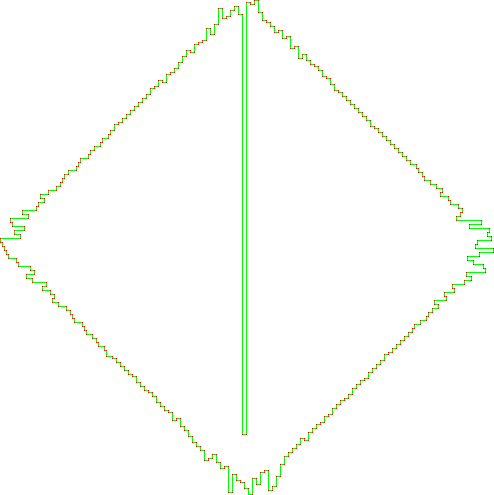

In [10]:
grid, *_ = create_grid(boundary(data))
draw_grid(grid)

Ok, so fortunately it's a single polygon.

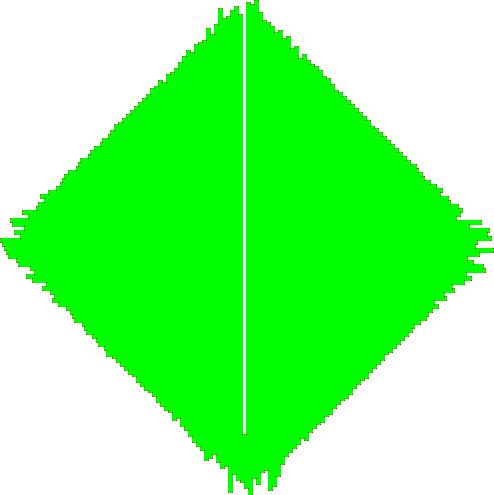

In [11]:
def complete_grid(boundary):
    grid, compressed_xs, compressed_ys, compressed_b = create_grid(boundary)
    starting_point = next(p for p in grid if p.x == 0)
    while starting_point in grid:
        starting_point += east()
    q = {starting_point}
    while q:
        p = q.pop()
        grid[p] = "green"
        for d in directions():
            if p + d not in grid:
                q.add(p + d)
    return grid, compressed_xs, compressed_ys, compressed_b
    
grid, *_ = complete_grid(boundary(data))
draw_grid(grid)

In [12]:
def valid_rectangles(data):
    b = boundary(data)
    grid, compressed_xs, compressed_ys, compressed_b = complete_grid(b)
    for i in tqdm.tqdm(range(len(compressed_b) - 1)):
        p1 = compressed_b[i]
        for j in range(i + 1, len(compressed_b)):
            p2 = compressed_b[j]
            if all(
                Point(x, y) in grid 
                for x in range(min(p1.x, p2.x), max(p1.x, p2.x) + 1)
                for y in range(min(p1.y, p2.y), max(p1.y, p2.y) + 1)
            ):
                yield area(b[i], b[j])

list(valid_rectangles(test_data))

100%|████████████████████████████| 7/7 [00:00<00:00, 41469.11it/s]


[3, 3, 1, 5, 15, 9, 5, 3, 9, 3, 8, 24, 9, 3, 12, 4]

In [13]:
def part_2(data):
    return max(valid_rectangles(data))

assert part_2(test_data) == 24

100%|████████████████████████████| 7/7 [00:00<00:00, 51150.05it/s]


In [14]:
%%time

part_2(data)

100%|███████████████████████████| 495/495 [01:06<00:00,  7.45it/s]

CPU times: user 1min 6s, sys: 716 ms, total: 1min 6s
Wall time: 1min 6s


1542084270

Wrong. I'm going to leave this one.